# 2. Hypothesis Testing and Upper Limits

## Recap

We defined our probability model and likelihood function for a simple one bin counting experiment with $n$ events, $s$ signal and $b$ background, in our signal region and $m$ events, $b$ background, in our control region:

$$
P(n, m; s, b) = \frac{(s+b)^n e^{-(s+b)}}{n!} \cdot \frac{b^m e^{-b}}{m!} = L(s, b),
$$ (model)

and our test statistic $\tilde{t}_s$:

$$
\tilde{\lambda}(s) = \left\{
    \begin{array}{ll}
      \frac{L(s, \hat{\hat{b}}(s))}{L(\hat{s}, \hat{b})}, & \mbox{$\hat{s}\geq0$}.\\
      \frac{L(s, \hat{\hat{b}}(s))}{L(0, \hat{\hat{b}}(0))}, & \mbox{$\hat{s}<0$}.
    \end{array}
  \right., \quad \tilde{t}_s=-2\ln \tilde{\lambda}(s),
$$ (ts_tilde)

and solved for $\hat{s}, \hat{b}, \hat{\hat{b}}(s)$ for given $n, m$ to find an analytic form for $t_s$.

Next, we want to translate this to a probability distribution of $t_s$ under a particular signal hypothesis ($H_s$) (i.e., an assumed value of $s$): $p(t_s|H_s)$, or just $p(t_s|s)$ for simplicity.

## Hypothesis testing

The goal of any experiment is to test whether our data support or exclude a particular hypothesis $H$, and quantify the (dis)agreement. For example, to what degree did our search for the Higgs boson agree or disagree with the standard model hypothesis? 

We have already discussed the process of mapping our data to a scalar test statistic $t$ that we can use to test $H$. However, we need to know the probability distribution of $t$ under $H$ to quantify the (in)consistency of the observed data with $H$ and decide whether or not to exclude $H$.

We also recognize that there's always a chance that we will exclude $H$ even if it's true (called a Type I error, or a false positive), or not exclude $H$ when it's false (Type II error, or false negative). The probability of each is referred to as $\alpha$ and $\beta$, respectively. See this handy table from [Wikipedia](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors):

```{figure} figures/table_error_types.png
---
width: 400px
align: center
---
```

Before the test, we should decide on a probability of making a Type I error, $\alpha$, that we are comfortable with, called a "significance level". Typical values are 5% and 1%, although if we're claiming something crazy like a new particle, we better be very sure this isn't a false positive; hence, we set a much lower significance level for these tests of $3\times10^{-7}$. (The *significance* of this value will be explained below.)

### Deriving $p(t_s|s)$

We can approximate $p(t_s|s)$ by generating several psuedo- or "toy" datasets assuming $s$ expected signal events. In this case, this means sampling possible values for $n, m$.

```{note}
One complication is that the $n, m$ distributions from which we want to sample (Eq. {eq}`model`) also depend on the nuisance parameter $b$. However, we'll see that this won't matter as much we might expect.
```

In [45]:
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, chi2
import warnings
from IPython.display import display, Markdown, Latex

plt.rcParams.update({"font.size": 16})
warnings.filterwarnings("ignore")

In [23]:
def log_poisson_nofactorial(n, mu):
    return -mu + n * np.log(mu)


def log_likelihood_nofactorial(s, b, n, m):
    return log_poisson_nofactorial(n, s + b) + log_poisson_nofactorial(m, b)


def shat(n, m):
    return n - m


def bhat(n, m):
    return m


def bhathat(s, n, m):
    """Using the quadratic formula and only the positive solution"""
    return ((n + m - 2 * s) + np.sqrt((n + m - 2 * s) ** 2 + 8 * s * m)) / 4


def t_s(s, n, m, b=None):
    """-2ln(lambda), b can optionally be fixed (for demo below)"""
    bhh, bh = (bhathat(s, n, m), bhat(n, m)) if b is None else (b, b)
    return -2 * (
        log_likelihood_nofactorial(s, bhh, n, m)
        - log_likelihood_nofactorial(shat(n, m), bh, n, m)
    )


def t_zero_s(s, n, m):
    """Alternative test statistic when shat < 0"""
    return -2 * (
        log_likelihood_nofactorial(s, bhathat(s, n, m), n, m)
        - log_likelihood_nofactorial(0, bhathat(0, n, m), n, m)
    )


def t_tilde_s(s, n, m):
    #     s, n, m = [np.array(x) for x in (s, n, m)]  # convert to numpy arrays
    neg_shat_mask = shat(n, m) < 0  # find when s^ is < 0
    ts = np.array(t_s(s, n, m))
    t_zero = t_zero_s(s, n, m)
    # replace values where s^ < 0 with lam_zero
    ts[neg_shat_mask] = t_zero[neg_shat_mask]
    return ts.squeeze()

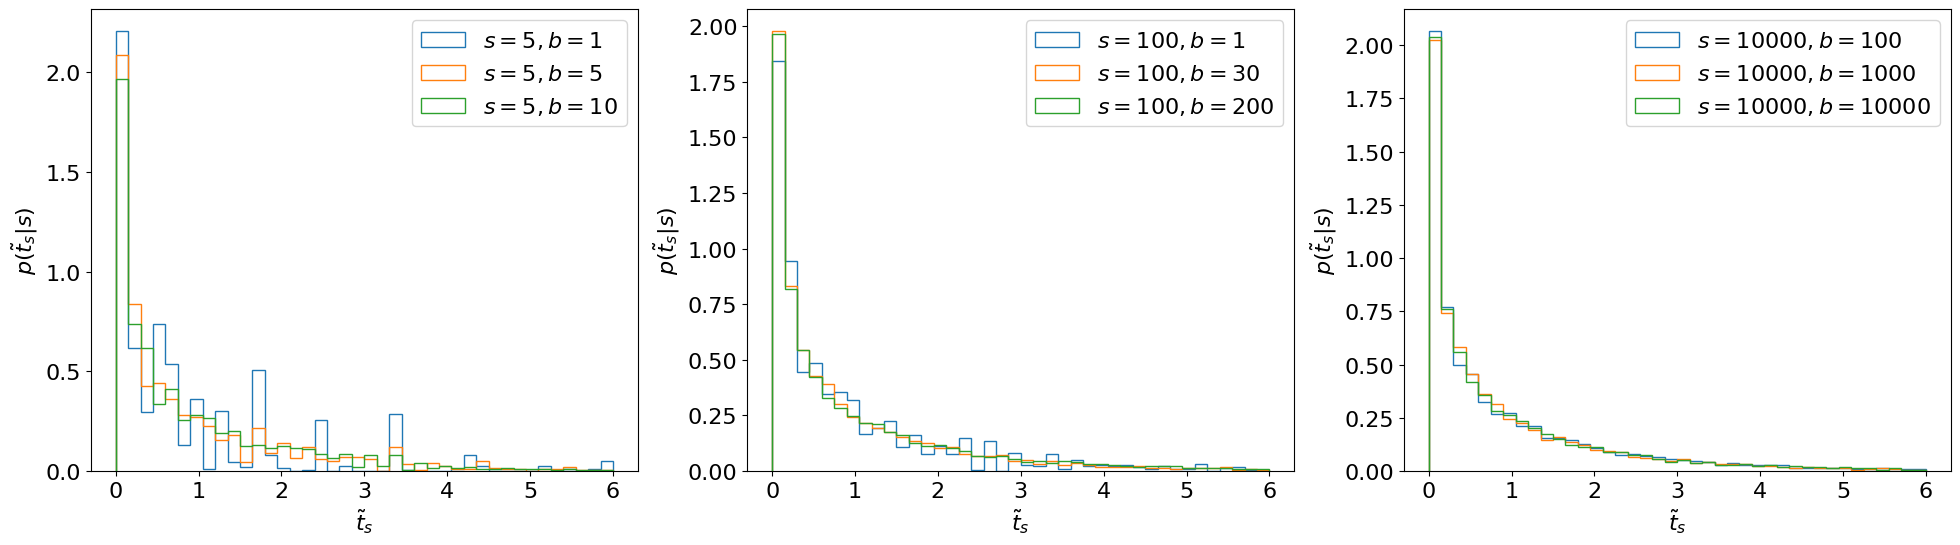

In [24]:
num_toys = 10000
sbs = [
    [(5.0, 1.0), (5.0, 5.0), (5.0, 10.0)],
    [(100, 1), (100, 30), (100, 200)],
    [(10000, 100), (10000, 1000), (10000, 10000)],
]

fig, axs = plt.subplots(1, 3, figsize=(24, 6))
for i, sb in enumerate(sbs):
    for s, b in sb:
        # sample n, m according to our data model (Eq. 1)
        n, m = poisson.rvs(s + b, size=num_toys), poisson.rvs(b, size=num_toys)
        axs[i].hist(
            t_tilde_s(s, n, m),
            np.linspace(0, 6, 41),
            histtype="step",
            density=True,
            label=rf"$s = {int(s)}, b = {int(b)}$",
        )

    axs[i].legend()
    axs[i].set_xlabel(r"$\tilde{t}_s$")
    axs[i].set_ylabel(r"$p(\tilde{t}_s|s)$")
    
plt.show()

```{admonition} Observations
:class: important
 - $p(\tilde{t}_s|s)$ does not depend on nuisance parameters ($b$) as long as $b$ is sufficiently large (this is a key reason for basing our test statistic on the profile likelihood).
 - In fact, $p(\tilde{t}_s|s)$ doesn't even depend on $s$! (Again, as long as $s$ is large.)
```
 
Ref. {cite}`Cowan:2010js` shows that, asymptotically, this distribution follows a $\chi^2$ distribution with degrees of freedom = # of parameters of interest. You can see the derivation in the reference therein but, essentially, like with most things in physics, this follows from Taylor expanding around the minimum...

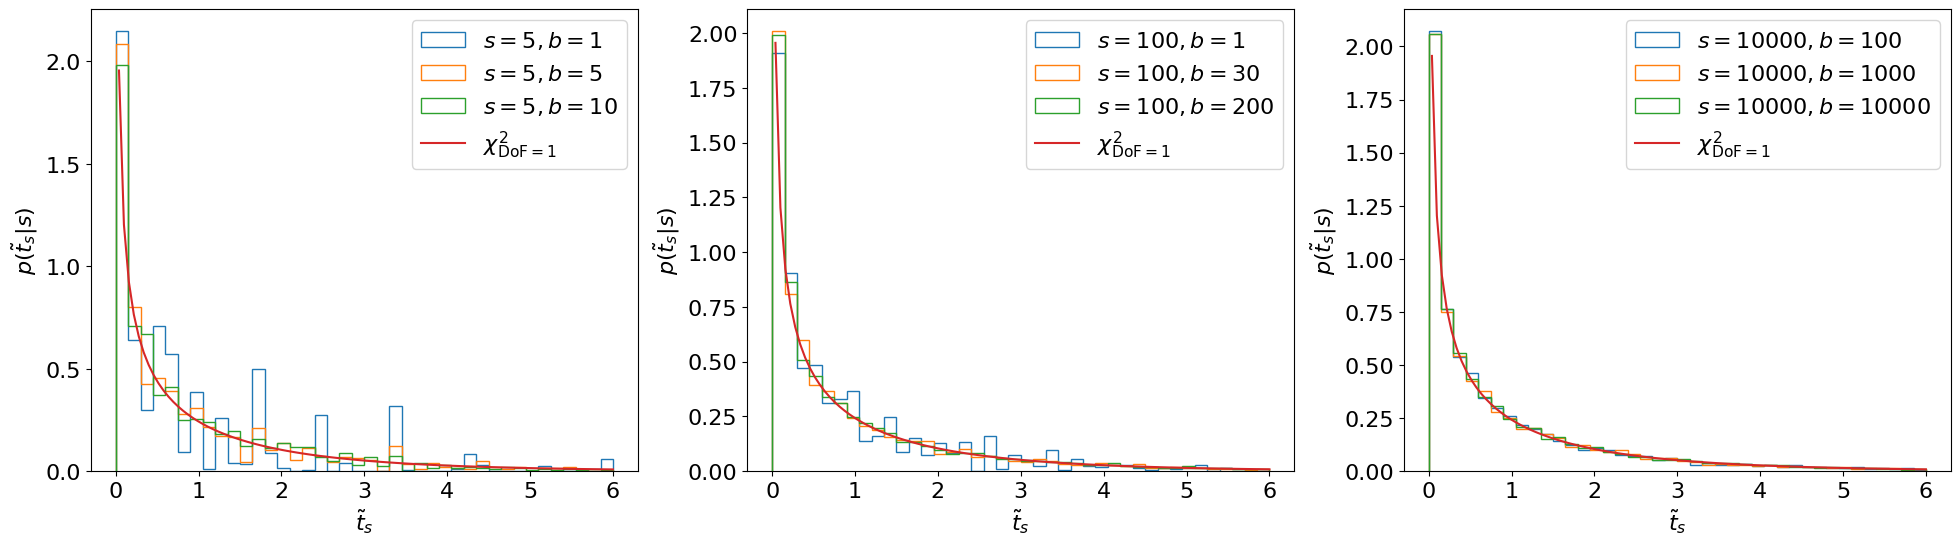

In [25]:
num_toys = 10000
sbs = [
    [(5.0, 1.0), (5.0, 5.0), (5.0, 10.0)],
    [(100, 1), (100, 30), (100, 200)],
    [(10000, 100), (10000, 1000), (10000, 10000)],
]

fig, axs = plt.subplots(1, 3, figsize=(24, 6))
for i, sb in enumerate(sbs):
    for s, b in sb:
        # sample n, m according to our data model (Eq. 1)
        n, m = poisson.rvs(s + b, size=num_toys), poisson.rvs(b, size=num_toys)
        axs[i].hist(
            t_tilde_s(s, n, m),
            np.linspace(0, 6, 41),
            histtype="step",
            density=True,
            label=rf"$s = {int(s)}, b = {int(b)}$",
        )

    x = np.linspace(0.04, 6, 101)
    axs[i].plot(x, chi2.pdf(x, 1), label=r"$\chi^2_{\mathrm{DoF}=1}$")
    axs[i].legend()
    axs[i].set_xlabel(r"$\tilde{t}_s$")
    axs[i].set_ylabel(r"$p(\tilde{t}_s|s)$")

plt.show()

This asymptotic form looks accurate even for $s, b$ as low as ~5.
```{important}
For cases where you can't use the asymptotic form, Ref. {cite}`Cranmer:2014lly` recommends using $b = \hat{\hat{b}}(s)$ when generating toys, so that you (approximately) maximise the agreement with the hypothesis.
```

### $p$-values and Significance

Now that we know the distribution of the test statistic $p(\tilde{t}_s|H_s) \equiv p(\tilde{t}_s|s)$, we can finally test $H_s$ with our experiment.

Let's say we're testing the hypothesis of $s = 10$ signal events in our model and we observe $n = 20, m = 5$ events.
We can map this observation to our test statistic $\tilde{t}^\mathrm{obs}_s$:

In [49]:
s, n_obs, m_obs = 10, 20, 5
t_obs = t_tilde_s(s, n_obs, m_obs)
display(Latex(rf"$\tilde{{t}}^\mathrm{{obs}}_s = {t_obs:.2f}$"))

<IPython.core.display.Latex object>

And then see where this falls in our $p(\tilde{t}_s|s)$ distribution:

In [27]:
def get_toys(s, n_obs, m_obs, num_toys):
    """Generate toy data for a given s and observed n and m"""
    #  use b^^ for p(t_s|s) as recommended by Ref. 2
    b = bhathat(s, n_obs, m_obs)
    # sample n, m according to our data model (Eq. 1)
    n, m = poisson.rvs(s + b, size=num_toys), poisson.rvs(b, size=num_toys)
    
    return n, m


def get_p_ts(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """
    Get the t_tilde_s test statistic distribution via toys.
    By default, the s we're testing is the same as the s we're using for toys,
    but this can be changed if necessary (as you will see later).
    """
    if toy_s is None:
        toy_s = test_s
    n, m = get_toys(toy_s, n_obs, m_obs, num_toys)
    return t_tilde_s(test_s, n, m)


def get_ps_val(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """p value"""
    t_tilde_ss = get_p_ts(test_s, n_obs, m_obs, num_toys, toy_s)
    t_obs = t_tilde_s(test_s, n_obs, m_obs)
    p_val = np.mean(t_tilde_ss > t_obs)
    return p_val, t_tilde_ss, t_obs

In [28]:
def plot_p_ts(ax, test_s, n_obs, m_obs, t_tilde_ss, t_obs=None, p_value=None, Z=None, toy_s=None, p_s=True, hlim=6):
    if toy_s is None:
        toy_s = test_s
    
    test_s_label = "s" if test_s != 0 else "0"
    toy_s_label = "s" if toy_s != 0 else "0"
    
    h = ax.hist(
        t_tilde_ss,
        np.linspace(0, hlim, 41),
        histtype="step",
        density=True,
        label=fr"$p(\tilde{{t}}_{test_s_label}|{toy_s_label})$",
    )
    
    ylim = np.max(h[0]) * 1.1
    
    if t_obs is not None:
        ax.vlines(
            t_obs,
            0,
            ylim,
            linestyle="--",
            label=rf"$\tilde{{t}}^\mathrm{{obs}}_{test_s_label}$",
            color="red",
        )
    
    if p_value is not None:
        if p_s:
            p_label = f"$p = {p_value:.2f}$" if test_s !=0 else f"$p = {p_value:.3f}$"
            if Z is not None:
                p_label += f"\n$Z = {Z:.1f}$"

            ax.fill_between(
                x=h[1][1:],
                y1=h[0],
                where=h[1][1:] >= t_obs - 0.1,
                step="pre",
                label=p_label,
                facecolor="none",
                hatch="///",
                edgecolor="lightgreen"
            )
        else:
            p_label = f"$p_b = {p_value:.2f}$"
            ax.fill_between(
                x=h[1][:-1],
                y1=h[0],
                where=h[1][:-1] <= t_obs + 0.1,
                step="post",
                label=p_label,
                facecolor="none",
                edgecolor="lightpink",
                hatch=r"\\\\"
            )
    
    ax.set_ylim(0, ylim)
    ax.legend()
    ax.set_xlabel(rf"$\tilde{{t}}_{test_s_label}$")
    ax.set_title(
        f"$s = {int(test_s)}, n_\mathrm{{obs}} = {int(n_obs)}, m_\mathrm{{obs}} = {int(m_obs)}$"
    )

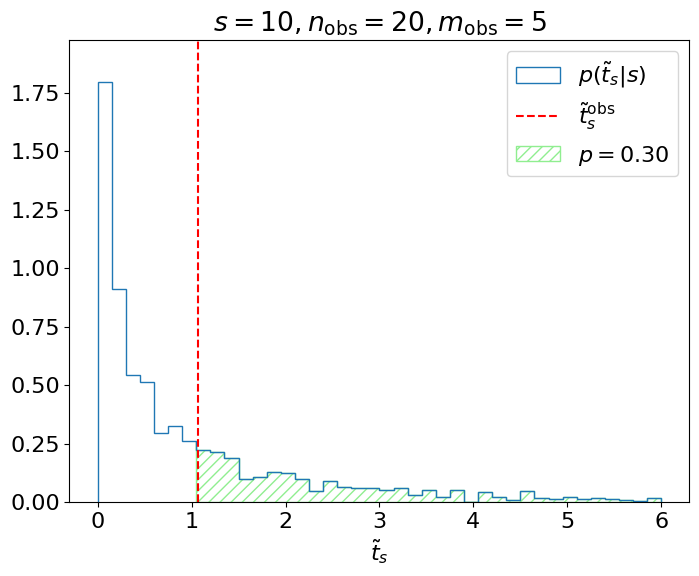

In [38]:
s, n_obs, m_obs = 10, 20, 5
p_value, t_tilde_ss, t_obs = get_ps_val(s, n_obs, m_obs, num_toys)

fig, ax = plt.subplots(figsize=(8, 6))
plot_p_ts(ax, s, n_obs, m_obs, t_tilde_ss, t_obs, p_value)
plt.show()

We care about, given $p(\tilde{t}_s|s)$, the probability of obtaining $\tilde{t}^\mathrm{obs}_s$ *or a value more inconsistent* with $H_s$; i.e., the orange shaded region above.
This is referred to as the *$p$-value* of the observation:

$$
p_s = \int_{\tilde{t}_\mathrm{obs}}^{\inf}p(\tilde{t}_s|s)\mathrm d \tilde{t}_s,
$$ (pvalue)

which is 0.3 for this example. We reject the hypothesis if this $p$-value is less than our chosen significance level $\alpha$; the idea being that if $H_s$ were true and we repeated this measurement many times, then the probability of a false-positive ($p$-value $\leq \alpha$) is exactly $\alpha$, as we intended.

Often the $p$-value is also "converted" into a *significance* ($Z$), which is the corresponding number of standard deviations away from the mean in a Gaussian distribution

$$
Z = \Phi^{-1}(1-p),
$$ (Z)

where $\Phi$ is the quantile of the standard Gaussian.
This is more easily illustrated in a figure (taken from Ref. {cite}`Cranmer:2014lly`), where $\varphi$ is the standard Gaussian distribution:

```{figure} figures/significance.png
---
align: center
name: 2sign
---
Significance from $p$-value.
```

The significance for this example is, therefore: 

In [50]:
# "ppf" = percent point function, which is what scipy calls the quantile function
Z = norm.ppf(1 - p_value)
display(Latex(f"$Z = {Z:.2f}$"))

<IPython.core.display.Latex object>

We sometimes say that our measurement is (in)consistent or (in)compatible with $H$ at the $0.54\sigma$ level, or within $1\sigma$, or ... the list goes on.

## Signal discovery

```{margin}
Note: Ref. {cite}`Cowan:2010js` refers to the special case of the test statistic $\tilde{t}_s$ for $s = 0$ as $q_0$.
```

Here, we were testing the signal hypothesis, but usually when we're searching for a particle, we actually test the "background-only" hypothesis $H_0$ and decide whether or not to reject it. This means we want $\tilde{t}^\mathrm{obs}_0$ and $p(\tilde{t}_0|0)$ (below). 

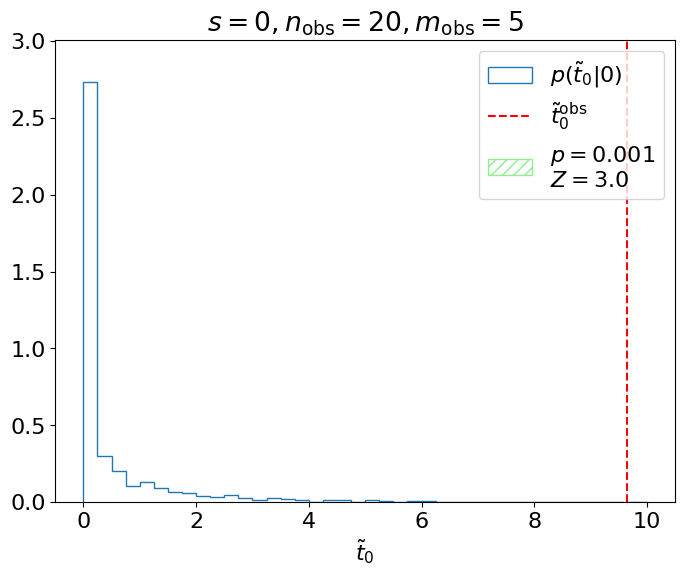

In [31]:
s, n_obs, m_obs = 0, 20, 5
p_value, t_tilde_ss, t_obs = get_ps_val(s, n_obs, m_obs, num_toys)
Z = norm.ppf(1 - p_value)

fig, ax = plt.subplots(figsize=(8, 6))
plot_p_ts(ax, s, n_obs, m_obs, t_tilde_ss, t_obs, p_value, Z, hlim=10)
plt.show()

We could say for this experiment, therefore, that we exclude the background-only hypothesis at the "3 sigma" level. However, if this were really a search for a new particle at the LHC, this would still not be enough to claim discovery, as the probability of a false positive at $3\sigma$, ~1/1000, is too high. The standard is instead set at $5\sigma$ for discovering new signals, corresponding to the $3\times10^{-7}$ significance level quoted earlier (we really don't want to be making a mistake if we're claiming to have discovered a new particle)! $3\sigma$, $4\sigma$, and $5\sigma$ are often referred to as evidence, observation, and discovery, respectively, of the signals we're searching for. TODO: check

## Summary

We went over the framework for hypothesis testing, which consists of:

1. Defining a test statistic $t$ to map data $\vec{x}$ (in our example, $\vec{x} = (n, m)$) to a single number.
2. Deriving the distribution of $t$ under the hypothesis being tested: $p(t|H)$ by sampling from "toy" datasets assuming $H$.
3. Quantifying the compatibility of the observed data $\vec{x}_\mathrm{obs}$ with $H$ via the $p$-value or significance $Z$ of $t_\mathrm{obs}$ relative to $p(t|H)$.

This $p$-value / significance is what we then use to decide whether or not to exclude $H$. A particularly important special case of this is testing the background-only hypothesis when trying to discover a signal.

In Part 3, I'll discuss going beyond testing to setting intervals and limits for parameters of interest.